In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

import sys, os, time, pickle
import numpy as np
import math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

!pip install torchsummary
!pip install einops

from torchsummary import summary

from math import ceil
import pywt

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from einops import reduce

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='A100-SXM4-40GB', major=8, minor=0, total_memory=40536MB, multi_processor_count=108)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys, os, time, pickle
import numpy as np
import math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

import torch.optim as optim
!pip install torchsummary
from torchsummary import summary
!pip install einops
from math import ceil
import pywt

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers
from einops import reduce

!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=pranavphoenix&password=Newton@13&submit=Login' https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1





--2022-04-26 03:18:07--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2022-04-26 03:18:08--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html’

index.html              [ <=>                ]  47.44K  --.-KB/s    in 0.1s    

2022-04-26 03:18:08 (362 KB/s) - ‘index.html’ saved [48580]

--2022-04-26 03:18:08--  https://www.cityscapes-dataset.com/file-handling/?packageID=3
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8

In [ ]:
!unzip -q /content/gtFine_trainvaltest.zip
!unzip -q /content/leftImg8bit_trainvaltest.zip

replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
dataset = torchvision.datasets.Cityscapes('/content/', split='train', mode='fine',
                      target_type='semantic')

In [ ]:
dataset[0][0].size

(2048, 1024)

In [ ]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']


class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19,
 255: 0}

In [ ]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [ ]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [ ]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [ ]:
!pip install opencv-python-headless==4.1.2.30
!pip install -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform=A.Compose(
[
    A.Resize(512, 1024),
    # A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

     |████████████████████████████████| 21.8 MB 5.7 MB/s 
     |████████████████████████████████| 102 kB 5.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']

In [ ]:
dataset=MyClass('/content/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
img,seg= dataset[20]
print(img.shape,seg.shape)

torch.Size([3, 512, 1024]) torch.Size([512, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


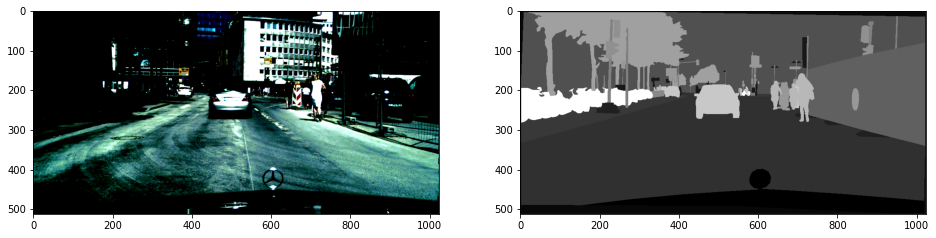

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')


In [ ]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

!pip install torchmetrics==0.7.3
import torchmetrics

     |████████████████████████████████| 88 kB 4.2 MB/s 
     |████████████████████████████████| 376 kB 25.6 MB/s 
     |████████████████████████████████| 58 kB 8.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=2afb912b5a4196b77456d2d8af72df1d49fc10aee792aadab9b0f79a5efa1003
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=a80e9a3a2a0998859867dcca94d280b14233d29f3e0dcf4346939eb6f456f83d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 398 kB 5.1 MB/s 


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.autograd import Function
import pywt
import torch.nn as nn
import functools

def sfb1d(lo, hi, g0, g1, mode='zero', dim=-1):
    """ 1D synthesis filter bank of an image tensor
    """
    C = lo.shape[1]
    d = dim % 4
    # If g0, g1 are not tensors, make them. If they are, then assume that they
    # are in the right order
    if not isinstance(g0, torch.Tensor):
        g0 = torch.tensor(np.copy(np.array(g0).ravel()),
                          dtype=torch.float, device=lo.device)
    if not isinstance(g1, torch.Tensor):
        g1 = torch.tensor(np.copy(np.array(g1).ravel()),
                          dtype=torch.float, device=lo.device)
    L = g0.numel()
    shape = [1,1,1,1]
    shape[d] = L
    N = 2*lo.shape[d]
    # If g aren't in the right shape, make them so
    if g0.shape != tuple(shape):
        g0 = g0.reshape(*shape)
    if g1.shape != tuple(shape):
        g1 = g1.reshape(*shape)

    s = (2, 1) if d == 2 else (1,2)
    g0 = torch.cat([g0]*C,dim=0)
    g1 = torch.cat([g1]*C,dim=0)
    if mode == 'per' or mode == 'periodization':
        y = F.conv_transpose2d(lo, g0, stride=s, groups=C) + \
            F.conv_transpose2d(hi, g1, stride=s, groups=C)
        if d == 2:
            y[:,:,:L-2] = y[:,:,:L-2] + y[:,:,N:N+L-2]
            y = y[:,:,:N]
        else:
            y[:,:,:,:L-2] = y[:,:,:,:L-2] + y[:,:,:,N:N+L-2]
            y = y[:,:,:,:N]
        y = roll(y, 1-L//2, dim=dim)
    else:
        if mode == 'zero' or mode == 'symmetric' or mode == 'reflect' or \
                mode == 'periodic':
            pad = (L-2, 0) if d == 2 else (0, L-2)
            y = F.conv_transpose2d(lo, g0, stride=s, padding=pad, groups=C) + \
                F.conv_transpose2d(hi, g1, stride=s, padding=pad, groups=C)
        else:
            raise ValueError("Unkown pad type: {}".format(mode))

    return y

def reflect(x, minx, maxx):
    """Reflect the values in matrix *x* about the scalar values *minx* and
    *maxx*.  Hence a vector *x* containing a long linearly increasing series is
    converted into a waveform which ramps linearly up and down between *minx*
    and *maxx*.  If *x* contains integers and *minx* and *maxx* are (integers +
    0.5), the ramps will have repeated max and min samples.
    .. codeauthor:: Rich Wareham <rjw57@cantab.net>, Aug 2013
    .. codeauthor:: Nick Kingsbury, Cambridge University, January 1999.
    """
    x = np.asanyarray(x)
    rng = maxx - minx
    rng_by_2 = 2 * rng
    mod = np.fmod(x - minx, rng_by_2)
    normed_mod = np.where(mod < 0, mod + rng_by_2, mod)
    out = np.where(normed_mod >= rng, rng_by_2 - normed_mod, normed_mod) + minx
    return np.array(out, dtype=x.dtype)

def mode_to_int(mode):
    if mode == 'zero':
        return 0
    elif mode == 'symmetric':
        return 1
    elif mode == 'per' or mode == 'periodization':
        return 2
    elif mode == 'constant':
        return 3
    elif mode == 'reflect':
        return 4
    elif mode == 'replicate':
        return 5
    elif mode == 'periodic':
        return 6
    else:
        raise ValueError("Unkown pad type: {}".format(mode))

def int_to_mode(mode):
    if mode == 0:
        return 'zero'
    elif mode == 1:
        return 'symmetric'
    elif mode == 2:
        return 'periodization'
    elif mode == 3:
        return 'constant'
    elif mode == 4:
        return 'reflect'
    elif mode == 5:
        return 'replicate'
    elif mode == 6:
        return 'periodic'
    else:
        raise ValueError("Unkown pad type: {}".format(mode))

def afb1d(x, h0, h1, mode='zero', dim=-1):
    """ 1D analysis filter bank (along one dimension only) of an image
    Inputs:
        x (tensor): 4D input with the last two dimensions the spatial input
        h0 (tensor): 4D input for the lowpass filter. Should have shape (1, 1,
            h, 1) or (1, 1, 1, w)
        h1 (tensor): 4D input for the highpass filter. Should have shape (1, 1,
            h, 1) or (1, 1, 1, w)
        mode (str): padding method
        dim (int) - dimension of filtering. d=2 is for a vertical filter (called
            column filtering but filters across the rows). d=3 is for a
            horizontal filter, (called row filtering but filters across the
            columns).
    Returns:
        lohi: lowpass and highpass subbands concatenated along the channel
            dimension
    """
    C = x.shape[1]
    # Convert the dim to positive
    d = dim % 4
    s = (2, 1) if d == 2 else (1, 2)
    N = x.shape[d]
    # If h0, h1 are not tensors, make them. If they are, then assume that they
    # are in the right order
    if not isinstance(h0, torch.Tensor):
        h0 = torch.tensor(np.copy(np.array(h0).ravel()[::-1]),
                          dtype=torch.float, device=x.device)
    if not isinstance(h1, torch.Tensor):
        h1 = torch.tensor(np.copy(np.array(h1).ravel()[::-1]),
                          dtype=torch.float, device=x.device)
    L = h0.numel()
    L2 = L // 2
    shape = [1,1,1,1]
    shape[d] = L
    # If h aren't in the right shape, make them so
    if h0.shape != tuple(shape):
        h0 = h0.reshape(*shape)
    if h1.shape != tuple(shape):
        h1 = h1.reshape(*shape)
    h = torch.cat([h0, h1] * C, dim=0)

    if mode == 'per' or mode == 'periodization':
        if x.shape[dim] % 2 == 1:
            if d == 2:
                x = torch.cat((x, x[:,:,-1:]), dim=2)
            else:
                x = torch.cat((x, x[:,:,:,-1:]), dim=3)
            N += 1
        x = roll(x, -L2, dim=d)
        pad = (L-1, 0) if d == 2 else (0, L-1)
        lohi = F.conv2d(x, h, padding=pad, stride=s, groups=C)
        N2 = N//2
        if d == 2:
            lohi[:,:,:L2] = lohi[:,:,:L2] + lohi[:,:,N2:N2+L2]
            lohi = lohi[:,:,:N2]
        else:
            lohi[:,:,:,:L2] = lohi[:,:,:,:L2] + lohi[:,:,:,N2:N2+L2]
            lohi = lohi[:,:,:,:N2]
    else:
        # Calculate the pad size
        outsize = pywt.dwt_coeff_len(N, L, mode=mode)
        p = 2 * (outsize - 1) - N + L
        if mode == 'zero':
            # Sadly, pytorch only allows for same padding before and after, if
            # we need to do more padding after for odd length signals, have to
            # prepad
            if p % 2 == 1:
                pad = (0, 0, 0, 1) if d == 2 else (0, 1, 0, 0)
                x = F.pad(x, pad)
            pad = (p//2, 0) if d == 2 else (0, p//2)
            # Calculate the high and lowpass
            lohi = F.conv2d(x, h, padding=pad, stride=s, groups=C)
        elif mode == 'symmetric' or mode == 'reflect' or mode == 'periodic':
            pad = (0, 0, p//2, (p+1)//2) if d == 2 else (p//2, (p+1)//2, 0, 0)
            x = mypad(x, pad=pad, mode=mode)
            lohi = F.conv2d(x, h, stride=s, groups=C)
        else:
            raise ValueError("Unkown pad type: {}".format(mode))

    return lohi



class AFB2D(Function):
    """ Does a single level 2d wavelet decomposition of an input. Does separate
    row and column filtering by two calls to
    :py:func:`pytorch_wavelets.dwt.lowlevel.afb1d`
    Needs to have the tensors in the right form. Because this function defines
    its own backward pass, saves on memory by not having to save the input
    tensors.
    Inputs:
        x (torch.Tensor): Input to decompose
        h0_row: row lowpass
        h1_row: row highpass
        h0_col: col lowpass
        h1_col: col highpass
        mode (int): use mode_to_int to get the int code here
    We encode the mode as an integer rather than a string as gradcheck causes an
    error when a string is provided.
    Returns:
        y: Tensor of shape (N, C*4, H, W)
    """
    @staticmethod
    def forward(ctx, x, h0_row, h1_row, h0_col, h1_col, mode):
        ctx.save_for_backward(h0_row, h1_row, h0_col, h1_col)
        ctx.shape = x.shape[-2:]
        mode = int_to_mode(mode)
        ctx.mode = mode
        lohi = afb1d(x, h0_row, h1_row, mode=mode, dim=3)
        y = afb1d(lohi, h0_col, h1_col, mode=mode, dim=2)
        s = y.shape
        y = y.reshape(s[0], -1, 4, s[-2], s[-1])
        low = y[:,:,0].contiguous()
        highs = y[:,:,1:].contiguous()
        return low, highs

    @staticmethod
    def backward(ctx, low, highs):
        dx = None
        if ctx.needs_input_grad[0]:
            mode = ctx.mode
            h0_row, h1_row, h0_col, h1_col = ctx.saved_tensors
            lh, hl, hh = torch.unbind(highs, dim=2)
            lo = sfb1d(low, lh, h0_col, h1_col, mode=mode, dim=2)
            hi = sfb1d(hl, hh, h0_col, h1_col, mode=mode, dim=2)
            dx = sfb1d(lo, hi, h0_row, h1_row, mode=mode, dim=3)
            if dx.shape[-2] > ctx.shape[-2] and dx.shape[-1] > ctx.shape[-1]:
                dx = dx[:,:,:ctx.shape[-2], :ctx.shape[-1]]
            elif dx.shape[-2] > ctx.shape[-2]:
                dx = dx[:,:,:ctx.shape[-2]]
            elif dx.shape[-1] > ctx.shape[-1]:
                dx = dx[:,:,:,:ctx.shape[-1]]
        return dx, None, None, None, None, None


def prep_filt_afb2d(h0_col, h1_col, h0_row=None, h1_row=None, device=device):
    """
    Prepares the filters to be of the right form for the afb2d function.  In
    particular, makes the tensors the right shape. It takes mirror images of
    them as as afb2d uses conv2d which acts like normal correlation.
    Inputs:
        h0_col (array-like): low pass column filter bank
        h1_col (array-like): high pass column filter bank
        h0_row (array-like): low pass row filter bank. If none, will assume the
            same as column filter
        h1_row (array-like): high pass row filter bank. If none, will assume the
            same as column filter
        device: which device to put the tensors on to
    Returns:
        (h0_col, h1_col, h0_row, h1_row)
    """
    h0_col, h1_col = prep_filt_afb1d(h0_col, h1_col, device)
    if h0_row is None:
        h0_row, h1_col = h0_col, h1_col
    else:
        h0_row, h1_row = prep_filt_afb1d(h0_row, h1_row, device)

    h0_col = h0_col.reshape((1, 1, -1, 1))
    h1_col = h1_col.reshape((1, 1, -1, 1))
    h0_row = h0_row.reshape((1, 1, 1, -1))
    h1_row = h1_row.reshape((1, 1, 1, -1))
    return h0_col, h1_col, h0_row, h1_row


def prep_filt_afb1d(h0, h1, device=device):
    """
    Prepares the filters to be of the right form for the afb2d function.  In
    particular, makes the tensors the right shape. It takes mirror images of
    them as as afb2d uses conv2d which acts like normal correlation.
    Inputs:
        h0 (array-like): low pass column filter bank
        h1 (array-like): high pass column filter bank
        device: which device to put the tensors on to
    Returns:
        (h0, h1)
    """
    h0 = np.array(h0[::-1]).ravel()
    h1 = np.array(h1[::-1]).ravel()
    t = torch.get_default_dtype()
    h0 = torch.tensor(h0, device=device, dtype=t).reshape((1, 1, -1))
    h1 = torch.tensor(h1, device=device, dtype=t).reshape((1, 1, -1))
    return h0, h1

class DWTForward(nn.Module):
    """ Performs a 2d DWT Forward decomposition of an image
    Args:
        J (int): Number of levels of decomposition
        wave (str or pywt.Wavelet or tuple(ndarray)): Which wavelet to use.
            Can be:
            1) a string to pass to pywt.Wavelet constructor
            2) a pywt.Wavelet class
            3) a tuple of numpy arrays, either (h0, h1) or (h0_col, h1_col, h0_row, h1_row)
        mode (str): 'zero', 'symmetric', 'reflect' or 'periodization'. The
            padding scheme
        """
    def __init__(self, J=1, wave='db1', mode='zero'):
        super().__init__()
        if isinstance(wave, str):
            wave = pywt.Wavelet(wave)
        if isinstance(wave, pywt.Wavelet):
            h0_col, h1_col = wave.dec_lo, wave.dec_hi
            h0_row, h1_row = h0_col, h1_col
        else:
            if len(wave) == 2:
                h0_col, h1_col = wave[0], wave[1]
                h0_row, h1_row = h0_col, h1_col
            elif len(wave) == 4:
                h0_col, h1_col = wave[0], wave[1]
                h0_row, h1_row = wave[2], wave[3]

        # Prepare the filters
        filts = prep_filt_afb2d(h0_col, h1_col, h0_row, h1_row)
        self.register_buffer('h0_col', filts[0])
        self.register_buffer('h1_col', filts[1])
        self.register_buffer('h0_row', filts[2])
        self.register_buffer('h1_row', filts[3])
        self.J = J
        self.mode = mode

    def forward(self, x):
        """ Forward pass of the DWT.
        Args:
            x (tensor): Input of shape :math:`(N, C_{in}, H_{in}, W_{in})`
        Returns:
            (yl, yh)
                tuple of lowpass (yl) and bandpass (yh) coefficients.
                yh is a list of length J with the first entry
                being the finest scale coefficients. yl has shape
                :math:`(N, C_{in}, H_{in}', W_{in}')` and yh has shape
                :math:`list(N, C_{in}, 3, H_{in}'', W_{in}'')`. The new
                dimension in yh iterates over the LH, HL and HH coefficients.
        Note:
            :math:`H_{in}', W_{in}', H_{in}'', W_{in}''` denote the correctly
            downsampled shapes of the DWT pyramid.
        """
        yh = []
        ll = x
        mode = mode_to_int(self.mode)

        # Do a multilevel transform
        for j in range(self.J):
            # Do 1 level of the transform
            ll, high = AFB2D.apply(
                ll, self.h0_col, self.h1_col, self.h0_row, self.h1_row, mode)
            yh.append(high)

        return ll, yh



    
xf1 = DWTForward(J=1, wave='db1').cuda()

from numpy.lib.function_base import hamming
import pywt
class Waveblock(nn.Module):
    def __init__(
        self,
        *,
        # mult_dim = 32,
        mult = 2,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.5,
    ):
        super().__init__()

        self.feedforward = nn.Sequential(
                nn.Conv2d(final_dim, final_dim*mult,1),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Conv2d(final_dim*mult, ff_channel, 1),
#                 nn.Dropout(dropout),
            )
      
        self.ff1 = nn.ConvTranspose2d(ff_channel, final_dim, 4, stride=2, padding=1)



        self.depthconv = nn.Sequential(
            
            nn.BatchNorm2d(final_dim),
        )

        self.reduction = nn.Conv2d(final_dim, int(final_dim/4), 1)
        
        
    def forward(self, x):
        b, c, h, w = x.shape
        
        x = self.reduction(x)
        
        Y1, Yh = xf1(x)

        x1 = torch.reshape(Yh[0], (b, int(c*3/4), int(h/2), int(w/2)))

        x1 = torch.cat((Y1,x1), dim = 1)

        x1 = self.feedforward(x1)

        x1 = self.ff1(x1)

        x = self.depthconv(x1)
        
        return x
        

class WaveMix(nn.Module):
    def __init__(
        self,
        *,
        num_classes,
        depth,
        # mult_dim = 32,
        mult = 2,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.,
    ):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(Waveblock(mult = mult, ff_channel = ff_channel, final_dim = final_dim, dropout = dropout))

        self.segment = nn.Sequential(
            nn.ConvTranspose2d(final_dim,int(final_dim/2), 4, stride=2, padding=1),
            nn.ConvTranspose2d(int(final_dim/2),int(final_dim/4), 4, stride=2, padding=1),
            nn.Conv2d(int(final_dim/4), num_classes, 1)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(3, int(final_dim/2), 3, 2, 1),
            nn.Conv2d(int(final_dim/2), final_dim, 3, 2, 1)
        )

      

    def forward(self, img):
        x = self.conv(img)   
            
        for attn in self.layers:
            x = attn(x) + x

        out = self.segment(x)

        return out

model = WaveMix(
    num_classes = 20,
    depth = 8,
    mult = 2,
    ff_channel = 128,
    final_dim = 128,
    dropout = 0.5
)


In [ ]:

model.to(device)
print(summary(model,(3,512,1024)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 512]           1,792
            Conv2d-2        [-1, 128, 128, 256]          73,856
            Conv2d-3         [-1, 32, 128, 256]           4,128
            Conv2d-4         [-1, 256, 64, 128]          33,024
              GELU-5         [-1, 256, 64, 128]               0
           Dropout-6         [-1, 256, 64, 128]               0
            Conv2d-7         [-1, 128, 64, 128]          32,896
   ConvTranspose2d-8        [-1, 128, 128, 256]         262,272
       BatchNorm2d-9        [-1, 128, 128, 256]             256
        Waveblock-10        [-1, 128, 128, 256]               0
           Conv2d-11         [-1, 32, 128, 256]           4,128
           Conv2d-12         [-1, 256, 64, 128]          33,024
             GELU-13         [-1, 256, 64, 128]               0
          Dropout-14         [-1, 256, 

In [ ]:
# criterion= smp.losses.DiceLoss(mode='multiclass')
criterion = nn.CrossEntropyLoss()
metrics = torchmetrics.IoU(num_classes=n_classes)

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: FutureWarning: The `IoU` was deprecated since v0.7 in favor of `torchmetrics.classification.jaccard.JaccardIndex`. It will be removed in v0.8.
  stream(template_mgs % msg_args)


In [ ]:
trainset = MyClass('/content/', split='train', mode='fine',
                     target_type='semantic',transforms=transform)
testset= MyClass('/content/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)

In [ ]:
batch_size = 32

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    outputs = outputs.argmax(dim=1)

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    
    

In [ ]:
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
miou = []
epoch_losses = []
test_losses = []

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# I refered https://github.com/c0nn3r/RetinaNet/blob/master/focal_loss.py

class FocalLoss2d(nn.Module):

    def __init__(self, gamma=2, weight=None, size_average=True):
        super(FocalLoss2d, self).__init__()

        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.contiguous().view(input.size(0), input.size(1), -1)
            input = input.transpose(1,2)
            input = input.contiguous().view(-1, input.size(2)).squeeze()
        if target.dim()==4:
            target = target.contiguous().view(target.size(0), target.size(1), -1)
            target = target.transpose(1,2)
            target = target.contiguous().view(-1, target.size(2)).squeeze()
        elif target.dim()==3:
            target = target.view(-1)
        else:
            target = target.view(-1, 1)

        # compute the negative likelyhood
        weight = Variable(self.weight)
        logpt = -F.cross_entropy(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1-pt)**self.gamma) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:

criterion = FocalLoss2d()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 
for epoch in range(100):  # loop over the dataset multiple times
    t0 = time.time()
    epoch_accuracy = 0
    epoch_loss = 0
    running_loss = 0.0

    model.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        segment=encode_segmap(labels)

        with torch.cuda.amp.autocast():
            loss = criterion(outputs, segment.long())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)
    
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    epoch_losses.append(epoch_loss)
    test_loss = 0
    total = 0

    mIoU = 0
    model.eval()
    t1 = time.time()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # labels = labels.squeeze(1).long()
            outputs = model(images)
            segment=encode_segmap(labels)
#         outputs = net(images)

            # _, predicted = torch.max(outputs.data, 1)
            with torch.cuda.amp.autocast():
              test_loss += criterion(outputs, segment.long())
              # mIoU = metrics(outputs, labels)
              # mIoU +=  metrics(outputs,segment)
            mIoU += iou_pytorch(outputs, segment).mean()
          
    
    mIoU = mIoU/len(testloader)
    test = test_loss/len(testloader)
    test_losses.append(test)
    mIoU = mIoU.cpu().detach()
    miou.append(mIoU)

    print(f"Epoch : {epoch+1} - train loss : {epoch_loss:.4f} - test loss: {test_loss:.4f}- MIOU: {mIoU:.4f} - Train Time: {t1 - t0:.1f} -Test Time: {time.time() - t1:.1f}\n")
    if mIoU >= max(miou):
        PATH = '/content/drive/MyDrive/PhD Thesis/Cityscapes/WaveMix128Citydatalayer8_512by1024focal.pth'
        torch.save(model.state_dict(), PATH)
        print(1)

    
print('Finished Training')

Epoch : 1 - train loss : 0.0300 - test loss: 1.1641- MIOU: 0.6596 - Train Time: 190.1 -Test Time: 33.2

1
Epoch : 2 - train loss : 0.0289 - test loss: 1.1392- MIOU: 0.6615 - Train Time: 189.6 -Test Time: 33.6

1
Epoch : 3 - train loss : 0.0280 - test loss: 1.1311- MIOU: 0.6641 - Train Time: 190.9 -Test Time: 33.7

1
Epoch : 4 - train loss : 0.0277 - test loss: 1.1164- MIOU: 0.6645 - Train Time: 186.8 -Test Time: 33.5

1
Epoch : 5 - train loss : 0.0277 - test loss: 1.1420- MIOU: 0.6630 - Train Time: 188.8 -Test Time: 33.5

Epoch : 6 - train loss : 0.0271 - test loss: 1.0954- MIOU: 0.6648 - Train Time: 191.1 -Test Time: 33.1

1
Epoch : 7 - train loss : 0.0272 - test loss: 1.1056- MIOU: 0.6656 - Train Time: 189.9 -Test Time: 33.7

1
Epoch : 8 - train loss : 0.0269 - test loss: 1.0961- MIOU: 0.6665 - Train Time: 188.6 -Test Time: 33.7

1
Epoch : 9 - train loss : 0.0267 - test loss: 1.0995- MIOU: 0.6646 - Train Time: 191.4 -Test Time: 32.9

Epoch : 10 - train loss : 0.0268 - test loss: 1.07

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/PhD Thesis/Cityscapes/WaveMix128Citypairlayer8.pth'))

<All keys matched successfully>

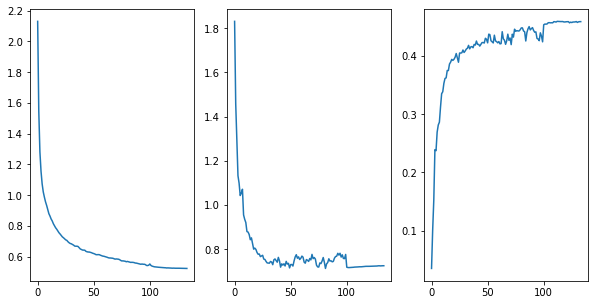

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].plot(epoch_losses)
axes[1].plot(test_losses)
axes[2].plot(miou)

In [ ]:
# from sklearn.metrics import confusion_matrix
# from tabulate import tabulate

# def evaluate_single(seg_map, ground_truth):
#     """Evaluate a single frame with the MODEL loaded."""    
#     # merge label due to different annotation scheme
#     # seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
#     # seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
#     # seg_map[seg_map==12] = 11

#     # calculate accuracy on valid area
#     acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)
    
#     # select valid labels for evaluation
#     cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19], 
#                           labels=np.array([0,1,2,5,6,7,8,9,11,13]))
#     intersection = np.diag(cm)
#     union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
#     return acc, intersection, union


# print('evaluating on the sample image...')

# original_im = trainset[0][0]
# seg_map = model(original_im.unsqeeze(0).cuda())
# gt = trainset[0][1]  # sample image is frame 0
# acc, intersection, union = evaluate_single(seg_map, gt)
# class_iou = np.round(intersection / union, 5)
# print('pixel accuracy: %.5f'%acc)
# print('mean class IoU:', np.mean(class_iou))
# # print('class IoU:')
# # print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

## 7. Check model predictions

In [ ]:

model_ = WaveMix(
    num_classes = 20,
    depth = 8,
    mult = 2,
    ff_channel = 128,
    final_dim = 128,
    dropout = 0.5).to(device)
# model_ = ResNetUNet(34).to(device)
model_.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
X, Y = next(iter(test_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
miou = iou_pytorch(Y_pred, Y)
Y_pred = torch.argmax(Y_pred, dim=1)


In [ ]:
# miou=miou.cpu().detach()
miou = miou.tolist()

In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

96
96
96
96
96
96
96
96
96
96
96


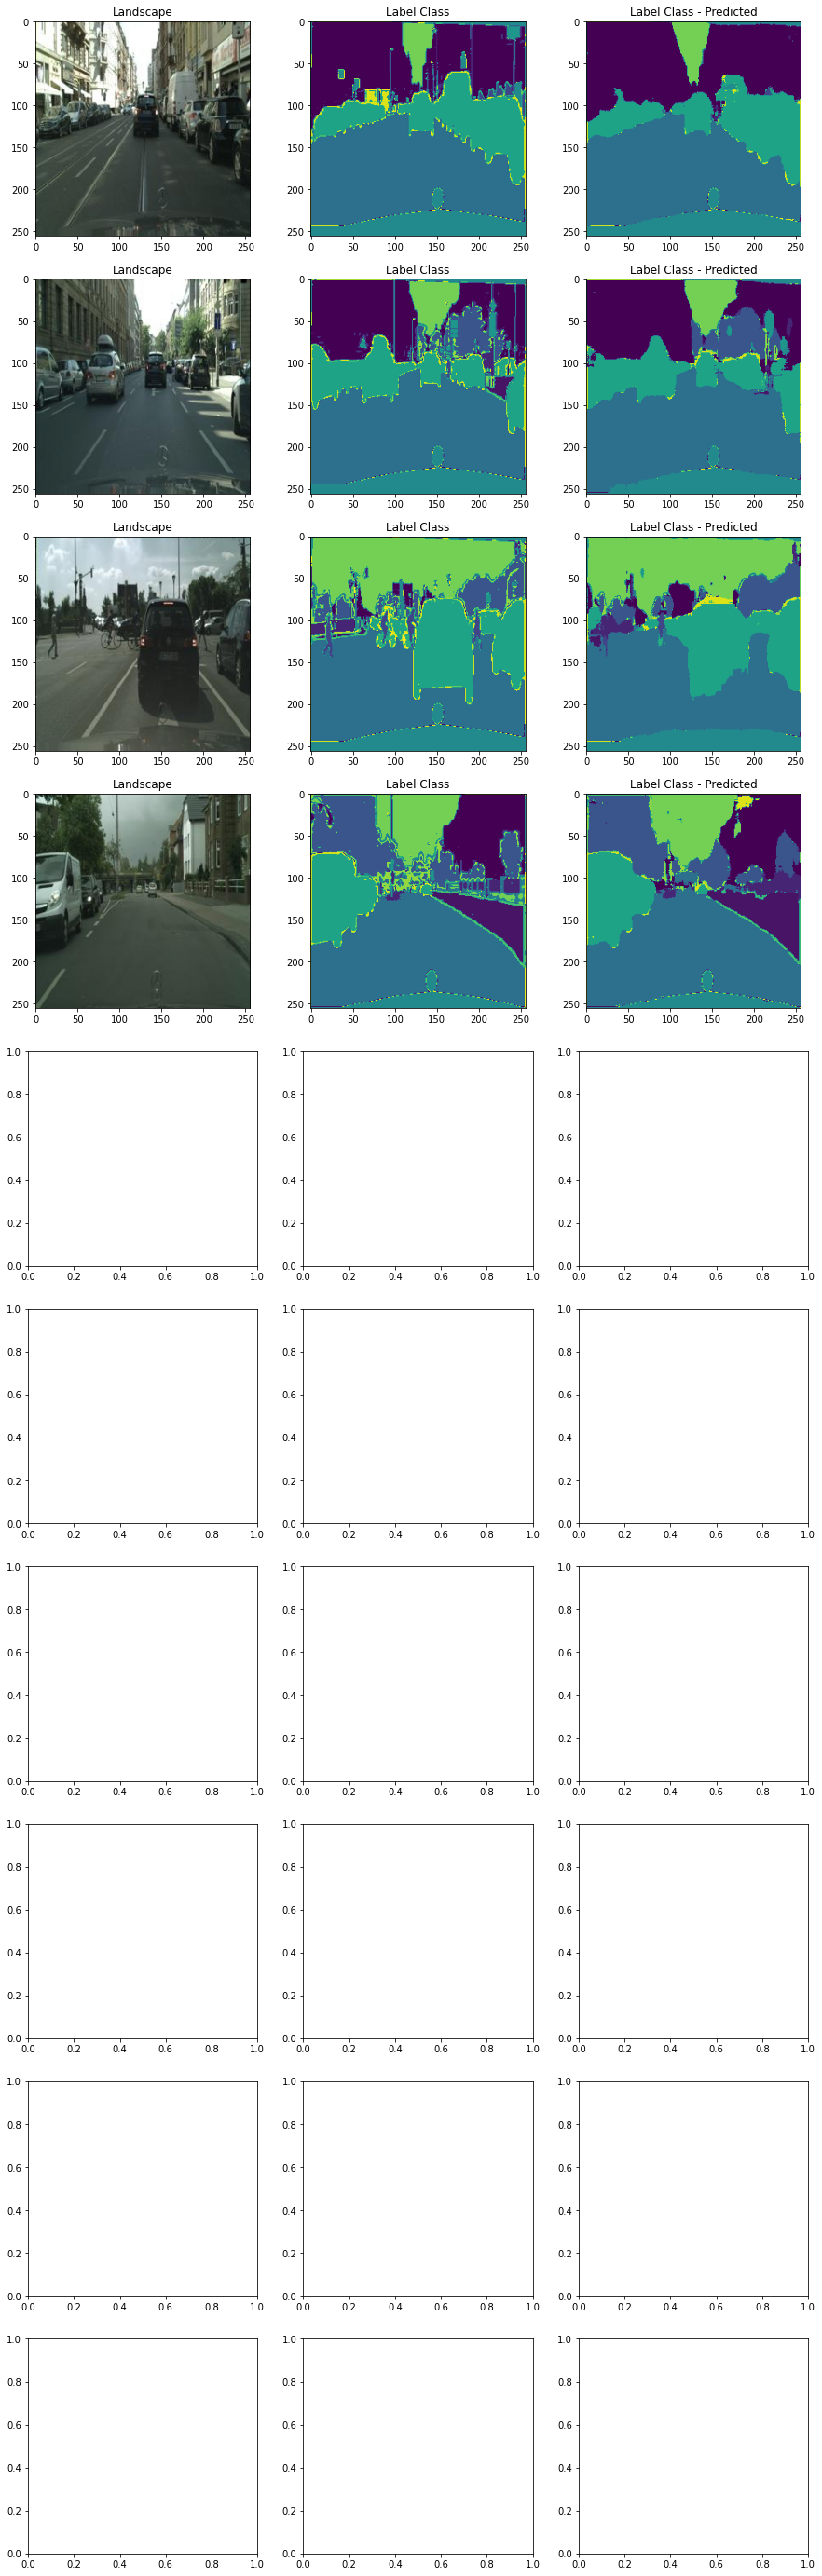

In [ ]:

fig, axes = plt.subplots(10, 3, figsize=(3*5, 10*5))


def Nmaxelements(list1, N):
    top = []
    list2 = list1.copy()

    for i in range(N):
      indices = [i for i, x in enumerate(list1) if x == max(list1)]
      top.append(indices)
      # list2.remove(max(list2))
      print(len(list1))
      # print(len(list2))

    return top


x  = Nmaxelements(miou, 10)
# print(x)
print(len(miou))
j = 0
for i in [i for i, x in enumerate(miou) if x == max(miou)]:
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[j, 0].imshow(landscape)
    axes[j, 0].set_title("Landscape")
    axes[j, 1].imshow(label_class)
    axes[j, 1].set_title("Label Class")
    axes[j, 2].imshow(label_class_predicted)
    axes[j, 2].set_title("Label Class - Predicted")
    j+=1